In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import  train_test_split
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis

Using TensorFlow backend.
/Users/dmodh/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
prices_dataset =  pd.read_csv('nyse/prices.csv', header=0)

In [3]:
len(set(prices_dataset['symbol']))

501

In [4]:
yahoo = prices_dataset[prices_dataset['symbol']=='YHOO']
yahoo_stock_prices = yahoo.close.values.astype('float32')
yahoo_stock_prices = yahoo_stock_prices.reshape(1762, 1)
yahoo_stock_prices.shape

(1762, 1)

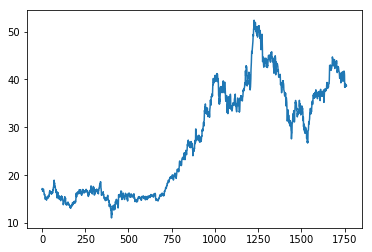

In [5]:
plt.plot(yahoo_stock_prices)
plt.show()

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
yahoo_stock_prices = scaler.fit_transform(yahoo_stock_prices)

In [7]:
train_size = int(len(yahoo_stock_prices) * 0.80)
test_size = len(yahoo_stock_prices) - train_size
train, test = yahoo_stock_prices[0:train_size,:], yahoo_stock_prices[train_size:len(yahoo_stock_prices),:]

In [8]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        b = dataset[i+look_back,0] 
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [9]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)

In [10]:
testX, testY = create_dataset(test, look_back)

In [11]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [12]:
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    # to stack recurrent layers, you must use return_sequences=True
    # on any recurrent layer that feeds into another recurrent layer.
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

/Users/dmodh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/dmodh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=True, input_shape=(None, 1))`


('compilation time : ', 0.054028987884521484)


/Users/dmodh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


In [13]:
model.fit(
    trainX,
    trainY,
    batch_size=128,
    nb_epoch=10,
    # Fraction of the data to use as held-out validation data.
    validation_split=0.05)

/Users/dmodh/anaconda/lib/python2.7/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1336 samples, validate on 71 samples
Epoch 1/10
1336/1336 [==============================] - 2s - loss: 0.1399 - val_loss: 0.3267
Epoch 2/10
1336/1336 [==============================] - 0s - loss: 0.0801 - val_loss: 0.1727
Epoch 3/10
1336/1336 [==============================] - 0s - loss: 0.0462 - val_loss: 0.0784
Epoch 4/10
1336/1336 [==============================] - 0s - loss: 0.0343 - val_loss: 0.0454
Epoch 5/10
1336/1336 [==============================] - 0s - loss: 0.0250 - val_loss: 0.0303
Epoch 6/10
1336/1336 [==============================] - 0s - loss: 0.0148 - val_loss: 0.0123
Epoch 7/10
1336/1336 [==============================] - 0s - loss: 0.0070 - val_loss: 0.0040
Epoch 8/10
1336/1336 [==============================] - 0s - loss: 0.0026 - val_loss: 7.0468e-04
Epoch 9/10
1336/1336 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0013
Epoch 10/10
1336/1336 [==============================] - 0s - loss: 0.0020 - val_loss: 5.0332e-04


[[ 0.61013037]]
[[ 1.48612475]]
[[ 3.57147169]]
[[ 8.42237186]]
[[ 14.88401985]]


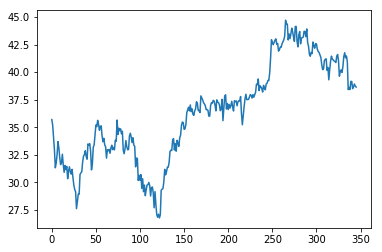

In [14]:
def plot_results_multiple(predicted_data, true_data, length):
    plt.plot(scaler.inverse_transform(true_data.reshape(-1, 1))[length:])
    plt.plot(scaler.inverse_transform(np.array(predicted_data).reshape(-1, 1))[length:])
    plt.show()
    
def predict_sequences_multiple(model, firstValue,length):
    prediction_seqs = []
    curr_frame = firstValue
    
    for i in range(length): 
        predicted = []        
        
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        
        curr_frame = curr_frame[0:]
        curr_frame = np.insert(curr_frame[0:], i+1, predicted[-1], axis=0)
        
        prediction_seqs.append(predicted[-1])
        
    return prediction_seqs

predict_length=5
predictions = predict_sequences_multiple(model, testX[0], predict_length)
plot_results_multiple(predictions, testY, predict_length)

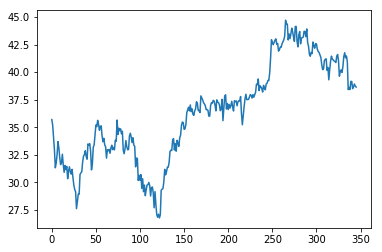

In [15]:
plt.plot(scaler.inverse_transform(testY.reshape(-1, 1))[5:])
plt.plot(scaler.inverse_transform(np.array(predictions).reshape(-1, 1))[5:])
plt.show()

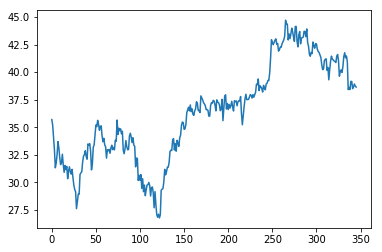

In [16]:
plot_results_multiple(predictions, testY, predict_length)